# Predicting car price from car features

In [1]:
#install tensorflow for neural network
!pip install --upgrade tensorflow
!pip install --upgrade keras

Requirement already up-to-date: tensorflow in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (2.1.0)
     |████████████████████████████████| 378kB 10.1MB/s eta 0:00:01
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


In [2]:
#install neccessary libraries and metrics
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, confusion_matrix,r2_score
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers, backend

Using TensorFlow backend.


In [3]:
#import data and select relevant features
df=pd.read_csv('fullspecs_cleaned.csv',index_col=0)

A=['Passenger Doors','Corrosion Miles/km',
            'Traction Control','Parking Aid','Width, Max w/o mirrors (in)','Basic Miles/km',
            'Drivetrain Miles/km','Gear','Horsepower','Roadside Assistance Years',
            'Daytime Running Lights','Basic Years',
            'Back-Up Camera','Horsepower RPM','EPA Fuel Economy Est - Hwy (MPG)',
            'Engine Configuration','Third Gear Ratio (:1)','Brakes-ABS',
            'Second Shoulder Room (in)','Stability Control','Drivetrain Years',
            'Tire Ratio',
            'Fourth Gear Ratio (:1)','Cylinders','Tire Pressure Monitor',
            'Corrosion Years','Torque RPM','Drivetrain','Rollover Protection Bars','Displacement (cc)',
            'Rear Tire Width','Make','Roadside Assistance Miles/km','Fifth Gear Ratio (:1)',
            'Front Shoulder Room (in)','Torque',
            'Front Leg Room (in)','Second Leg Room (in)','Front Head Room (in)',
            'Height, Overall (in)','Second Head Room (in)','Year',
            'Front Tire Width','Night Vision',
            'Tire Rating','Passenger Capacity',
            'Second Gear Ratio (:1)','Fuel Tank Capacity, Approx (gal)','Reverse Ratio (:1)',
            'Fuel System','First Gear Ratio (:1)','EPA Fuel Economy Est - City (MPG)',
            'Displacement (L)']
x=df.loc[:,A]
y=df['MSRP']

In [4]:
#one-hot encoding
to_dummies = ['Drivetrain','Fuel System', 'Engine Configuration','Tire Rating','Make']

for i in to_dummies:
    dummies = pd.get_dummies(x[i], prefix_sep=': ', prefix=i)
    x = x.drop(i, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

to_one = ['Brakes-ABS',
              'Daytime Running Lights','Traction Control','Night Vision','Rollover Protection Bars',
              'Parking Aid','Tire Pressure Monitor','Back-Up Camera','Stability Control']

for i in to_one:
    dummies1 = pd.get_dummies(x[i], prefix_sep=': ', prefix=i, drop_first=True)
    x = x.drop(i, axis=1)
    x = pd.concat([x, dummies1], sort=False, axis=1)
x = x.reset_index(drop=True)

In [5]:
#scale between 0 and 1
scaler = MinMaxScaler()
x = x.astype('float64')
x = scaler.fit_transform(x)

In [6]:
#check input shape
x.shape

(6119, 115)

In [7]:
#build a neural network model
model = Sequential([
    Dense(116, activation='relu',input_shape=(x.shape[1],)),
    Dense(58, activation='relu'),
    Dropout(0.05),
    Dense(1, activation='linear')])

In [8]:
#compile the model
model.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['mae'])

In [9]:
#train the model
history=model.fit(x,y, 
                  epochs=100,
                  validation_split=0.25,
                  batch_size=32,
                  callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)],
                  verbose=0)

Epoch 00056: early stopping


In [10]:
#print model accuracy
print('lowest validation mae: {}'.format(min(history.history['val_mae'])))
print('lowest validation mape: {}'.format(min(history.history['val_loss'])))

lowest validation mae: 5069.26611328125
lowest validation mape: 12.147387503331004


In [11]:
#review model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 116)               13456     
_________________________________________________________________
dense_2 (Dense)              (None, 58)                6786      
_________________________________________________________________
dropout_1 (Dropout)          (None, 58)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 59        
Total params: 20,301
Trainable params: 20,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
#review model evolution by epoch
history_df = pd.DataFrame(history.history)
history_df.index += 1
history_df.head()

,val_loss,val_mae,loss,mae
1,96.201628,34127.343750,99.032141,34286.148438
2,62.823056,23400.253906,81.859156,29087.027344
3,21.197253,8980.923828,34.345266,13641.000977
4,19.609498,8433.311523,22.348534,8611.866211
5,18.196666,7886.072754,19.291193,7805.691895


Text(0, 0.5, 'MAPE (%)')

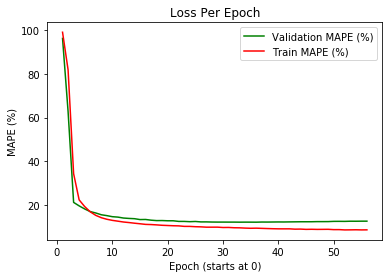

In [13]:
#display MAPE vs epoch (training loss and validation loss)
start = 0
stop = history_df.shape[0]
plt.plot(1+np.arange(start, stop), history_df['val_loss'][start:], c='green')
plt.plot(1+np.arange(start, stop), history_df['loss'][start:], c='red')
plt.legend(('Validation MAPE (%)', 'Train MAPE (%)'))
plt.title('Loss Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('MAPE (%)')

Text(0, 0.5, 'MAE')

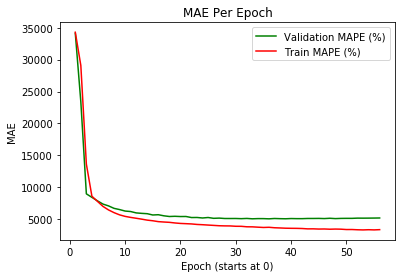

In [14]:
#display MAE vs epoch (training loss and validation loss)
plt.plot(1+np.arange(start, stop), history_df['val_mae'][start:], 'green')
plt.plot(1+np.arange(start, stop), history_df['mae'][start:], c='red')
plt.legend(('Validation MAPE (%)', 'Train MAPE (%)'))
plt.title('MAE Per Epoch')
plt.xlabel('Epoch (starts at {})'.format(start))
plt.ylabel('MAE')

In [15]:
#display actual vs predicted price
pred = model.predict(x)

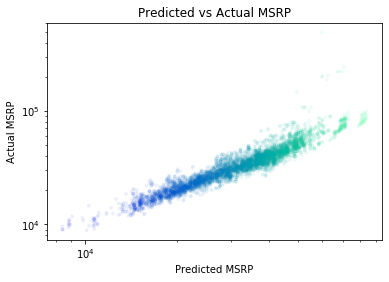

In [16]:
plt.scatter(pred, y, alpha=0.05, c=np.log(pred), cmap='winter', s=8) # winter, summer
plt.xlabel('Predicted MSRP')
plt.ylabel('Actual MSRP')
plt.title('Predicted vs Actual MSRP')
plt.yscale('log')
plt.xscale('log')

In [17]:
np.corrcoef(pred.ravel(), y)

array([[1.        , 0.83514453],
       [0.83514453, 1.        ]])

In [18]:
#compare result with linear regression
lin_reg = LinearRegression()

In [19]:
#select same features
A=['Passenger Doors','Corrosion Miles/km',
            'Traction Control','Parking Aid','Width, Max w/o mirrors (in)','Basic Miles/km',
            'Drivetrain Miles/km','Gear','Horsepower','Roadside Assistance Years',
            'Daytime Running Lights','Basic Years',
            'Back-Up Camera','Horsepower RPM','EPA Fuel Economy Est - Hwy (MPG)',
            'Engine Configuration','Third Gear Ratio (:1)','Brakes-ABS',
            'Second Shoulder Room (in)','Stability Control','Drivetrain Years',
            'Tire Ratio',
            'Fourth Gear Ratio (:1)','Cylinders','Tire Pressure Monitor',
            'Corrosion Years','Torque RPM','Drivetrain','Rollover Protection Bars','Displacement (cc)',
            'Rear Tire Width','Make','Roadside Assistance Miles/km','Fifth Gear Ratio (:1)',
            'Front Shoulder Room (in)','Torque',
            'Front Leg Room (in)','Second Leg Room (in)','Front Head Room (in)',
            'Height, Overall (in)','Second Head Room (in)','Year',
            'Front Tire Width','Night Vision',
            'Tire Rating','Passenger Capacity',
            'Second Gear Ratio (:1)','Fuel Tank Capacity, Approx (gal)','Reverse Ratio (:1)',
            'Fuel System','First Gear Ratio (:1)','EPA Fuel Economy Est - City (MPG)',
            'Displacement (L)']
x=df.loc[:,A]
y=df['MSRP']

In [20]:
#one-hot encoding
to_dummies = ['Drivetrain','Fuel System', 'Engine Configuration','Tire Rating','Make']

for i in to_dummies:
    dummies = pd.get_dummies(x[i], prefix_sep=': ', prefix=i)
    x = x.drop(i, axis=1)
    x = pd.concat([x, dummies], sort=False, axis=1)
x = x.reset_index(drop=True)

to_one = ['Brakes-ABS',
              'Daytime Running Lights','Traction Control','Night Vision','Rollover Protection Bars',
              'Parking Aid','Tire Pressure Monitor','Back-Up Camera','Stability Control']

for i in to_one:
    dummies1 = pd.get_dummies(x[i], prefix_sep=': ', prefix=i, drop_first=True)
    x = x.drop(i, axis=1)
    x = pd.concat([x, dummies1], sort=False, axis=1)
x = x.reset_index(drop=True)

In [21]:
#scale inputs
x = StandardScaler().fit_transform(x.astype(np.float64))

In [22]:
#split data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [23]:
#train linear regression model and review mae
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

2701.7283817173875

In [36]:
#review mae and r2 score
print('mean absolute error: '+ mean_absolute_error(y_test, y_pred).astype(str))
print('r2 score: '+ r2_score(y_test, y_pred).astype(str))

mean absolute error: 2701.7283817173875
r2 score: 0.946964932396114


In [ ]:
#train ridge regression model and review mae
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mean_absolute_error(y_test, y_pred)
print('mean absolute error: '+ mean_absolute_error(y_test, y_pred).astype(str))
print('r2 score: '+ r2_score(y_test, y_pred).astype(str))

In [ ]:
#review r2 score
r2_score(y_test, y_pred)